In [50]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Source: https://cs231n.github.io/neural-networks-case-study/#net

In [10]:
def generate_dataset(n_class_samples=100, n_features=2, n_classes=3):

    X = np.zeros((n_class_samples * n_classes, n_features))
    y = np.zeros(X.shape[0], dtype='uint8')
    
    for j in range(n_classes):
        ix = range(n_class_samples * j, n_class_samples * (j + 1))
        r = np.linspace(0.0, 1, n_class_samples)
        t = (np.linspace(j * 4, (j + 1) * 4, n_class_samples) +
             np.random.randn(n_class_samples) * 0.2)
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    return X, y  

def accuracy(y_true, y_pred):
    return (y_pred == y_true).mean()

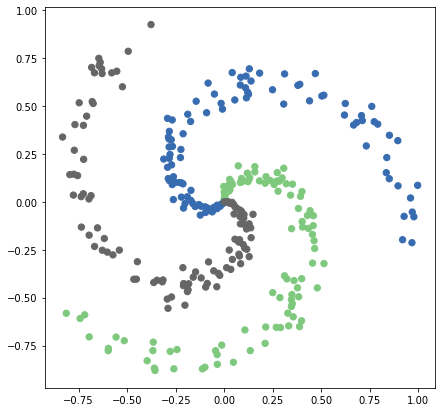

In [4]:
X, y = generate_dataset()
plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Accent)
plt.show()

In [110]:
def plot_regions(X, y, clf):
    x_min, y_min = X.min(axis=0).round() + 0.1
    x_max, y_max = X.max(axis=0).round() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplots(1, 1, figsize=(7, 7))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Accent)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Accent)
    plt.title(type(neural_clf).__name__)
    plt.show()

## Linear Classifier with Softmax Loss

In [56]:
class LinearClassifier:
    
    @staticmethod
    def _train(X, y, max_iter):
        # hyperparams, learning rate, regularization lambda
        lr = 1e-0
        reg = 1e-3
        
        n_samples, n_features = X.shape
        n_classes = np.unique(y).size

        # linear classifier weights
        # the matrices are transposed => (xW + b) instead of (Wx + b)
        # initial weights
        W = 0.01 * np.random.randn(n_features, n_classes)
        b = np.zeros((1, n_classes))

        for i in range(max_iter):

            # shape X dot W produces (300, 3) shape,
            # b (shape (1, 3)) is added automaticaly along the samples
            scores = np.dot(X, W) + b

            # for sample i, the classification produces 3 scores (one for each class)
            # using softmax, we convert the scores to probabilities and then
            # loss for sample i is the -log of the correct class probability 
            # (high probability => low loss)
            # loss for sample i := L_i = -log(softmax(scores_i)[y_i])

            exp_scores = np.exp(scores)
            # keepdims=True (300,) => (300, 1)
            # applying softmax to get probabilities of each class for each sample, shape (300 , 1)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # rows sumts to one
            assert (probs.sum(axis=1).round() == 1).all()

            # array loss function values L_i for each sample i
            # we take the probability of the correct class and apply the -log
            correct_logprobs = -np.log(probs[range(n_samples), y])

            # the full loss is the average L_i + regularization los
            # L := correct_logprobs.mean() + 1 / 2 * lambda * sum_i_n sum j_m (w_ij ^ 2)
            # reg = lambda
            data_loss = correct_logprobs.sum() / n_samples
            reg_loss = 0.5 * reg * np.sum(W ** 2)
            loss = data_loss + reg_loss

            # initial loss => 1 / 3 probability of assigning the correct class for each sample
            # -log(1 / 3) = 1.1
            # reg loss is very low and does not contribute very much to the ovrall loss
            if i == 0 or i == max_iter - 1:
                print(f'Iteration {i} loss: {loss:.2f}')

            # dL_i/df_i_k := gradient, change of loss function for sample i, 
            #                given the change of score f of class k
            # dL_i/df_i_k = p_i_k - 1(y_i == k), p is the normalized 
            # score (probability, softmax(f))
            # for p_i = [0.2, 0.3, 0.5], and correct class 1, 
            # the gradient at p_i is [0.2, 0.3 - 1, 0.5] = [0.2, -0.7, 0.5]
            # => the loss decreases if the probability of the correct class increases 
            #    (minus sign in the middle element)
            # => the loss increases if the probability of the incorect class increases

            # df = dscores, loss gradient based probs
            dscores = probs
            # according to the above,
            # loss gradient for sample i for incorrect classes is the same as the probability
            # gradient for the correct classes, is the class probability - 1
            dscores[range(n_samples), y] -= 1
            dscores /= n_samples
            # dscores, loss gradients for each sample

            # scores = np.dot(X, W) + b, we need to backproagate dscores to get dW and db
            dW = np.dot(X.T, dscores)
            db = np.sum(dscores, axis=0, keepdims=True)
            dW += reg * W # don't forget the regularization gradient
            # reg has the form of r(w) = 1 / 2 * lambda * w ** 2, so dr/dw = lambda * w

            # param update
            W += -lr * dW
            b += -lr * db
            
        return W, b
        
    def fit(self, X, y, max_iter=200):
        self._W, self._b = self._train(X, y, max_iter)
        return self
        
    def predict(self, X):
        scores = np.dot(X, self._W) + self._b
        return np.argmax(scores, axis=1)

In [57]:
X, y = generate_dataset()
linear_clf = LinearClassifier().fit(X, y)
acc = accuracy(y, linear_clf.predict(X))
print(f'accuracy: {acc:.2f}')

Iteration 0 loss: 1.10
Iteration 199 loss: 0.78
accuracy: 0.52


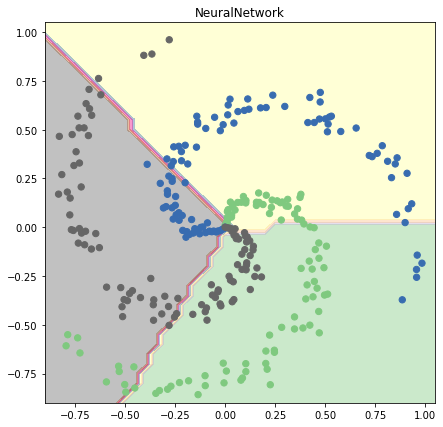

In [111]:
plot_regions(X, y, linear_clf)

# Neural Network

In [75]:
class NeuralNetwork:
    
    @staticmethod
    def _train(X, y, max_iter):
        # hyperparams, learning rate, regularization lambda
        lr = 1e-0
        reg = 1e-3
        
        n_samples, n_features = X.shape
        n_classes = np.unique(y).size
        
        # network with 2 layers, first is the hidden layer with 100 units
        # second layer is output layer with three neurons (3 classes)
        h = 100 # size of hidden layer
        W = 0.01 * np.random.randn(n_features, h)
        b = np.zeros((1, h))
        W2 = 0.01 * np.random.randn(h, n_classes)
        b2 = np.zeros((1, n_classes))
        
        for i in range(max_iter):
            # forward pass
            # max(0, Xw + b) is the application of ReLu relu on the raw output
            hidden_layer = np.maximum(0, np.dot(X, W) + b)
            # raw output of the second (output layer) are the scores (non normalized proabilites)
            scores = np.dot(hidden_layer, W2) + b2
        
            # everything same as with the softmax, except for the dscores backpropagation
            # (relation between the scores and weight is different)

            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            correct_logprobs = -np.log(probs[range(n_samples), y])

            data_loss = correct_logprobs.sum() / n_samples
            reg_loss = 0.5 * reg * np.sum(W ** 2)
            loss = data_loss + reg_loss

            dscores = probs
            dscores[range(n_samples), y] -= 1
            dscores /= n_samples
            
            # backprop
            # backprop dcores to dW2 is the same as the
            # softmax backprop, except hidden_layer of X
            dW2 = np.dot(hidden_layer.T, dscores)
            db2 = np.sum(dscores, axis=0, keepdims=True)
            
            dhidden = np.dot(dscores, W2.T)
            # backrpoagating from dhidden to dW
            # relu r(x) = max(0, x) => dr/dx = 1(x > 0), 0 for negative x, else 1
            # backward pass relu is like a switch, gradient passes unchanged if its input is > 0
            # gradient is killed if its input in forward pass was < 0
            dhidden[hidden_layer <= 0] = 0
            
            # backprop to dW, db
            dW = np.dot(X.T, dhidden)
            db = np.sum(dhidden, axis=0, keepdims=True)
            
            dW2 += reg * W2
            dW += reg * W
  
            # param update
            W += -lr * dW
            b += -lr * db
            W2 += -lr * dW2
            b2 += -lr * db2

        print(f'Iteration {max_iter} loss: {loss:.2f}')
        return W, b, W2, b2
        
    def fit(self, X, y, max_iter=10000):
        self._W, self._b, self._W2, self._b2 = self._train(X, y, max_iter)
        return self
        
    def predict(self, X):
        hidden_layer = np.maximum(0, np.dot(X, self._W) + self._b)
        scores = np.dot(hidden_layer, self._W2) + self._b2
        return np.argmax(scores, axis=1)

In [76]:
neural_clf = NeuralNetwork().fit(X, y)
acc = accuracy(y, neural_clf.predict(X))
print(f'accuracy: {acc:.2f}')

Iteration 10000 loss: 0.18
accuracy: 0.99


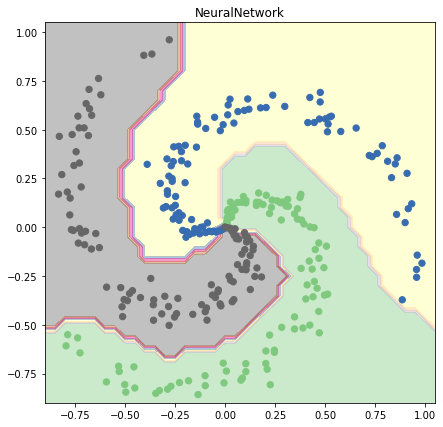

In [112]:
plot_regions(X, y, neural_clf)